In [72]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 데이터셋 다운로드 및 전처리

In [73]:
"""
데이터 불러오기
- df: 전세계의 일별 확진자, 사망자, 완치자에 대한 데이터
- confirmed : 국가별 확진자 수에 대한 sequence 데이터
"""
confirmed = pd.read_csv('data/time_series_covid19_confirmed_global.csv')
confirmed[confirmed['Country/Region']=='Korea, South']
korea = confirmed[confirmed['Country/Region']=='Korea, South'].iloc[:,4:].T
korea.index = pd.to_datetime(korea.index)
daily_cases = korea.diff().fillna(korea.iloc[0]).astype('int')

In [74]:
"""window size 별로 분할"""
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 5

X, y = create_sequences(daily_cases, seq_length)

In [75]:
"""[데이터개수, sequence_length]"""
## 총 327개의 데이터가 구성되었다.
print(X.shape, y.shape)

(327, 5, 1) (327, 1)


In [76]:
"""데이터 분리"""
train_size = int(327*0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
X_test, y_test = X[train_size+33:], y[train_size+33:]

In [77]:
"""scaling"""
MIN = X_train.min()
MAX = X_train.max()

def MinMaxScale(array, min, max):
    return (array-min)/(max-min)

#MinMax 스케일링
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

## 텐서 형태로 변환
def make_Tensor(array):
    return torch.from_numpy(array).float()

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

In [79]:
X_train.shape

torch.Size([261, 5, 1])

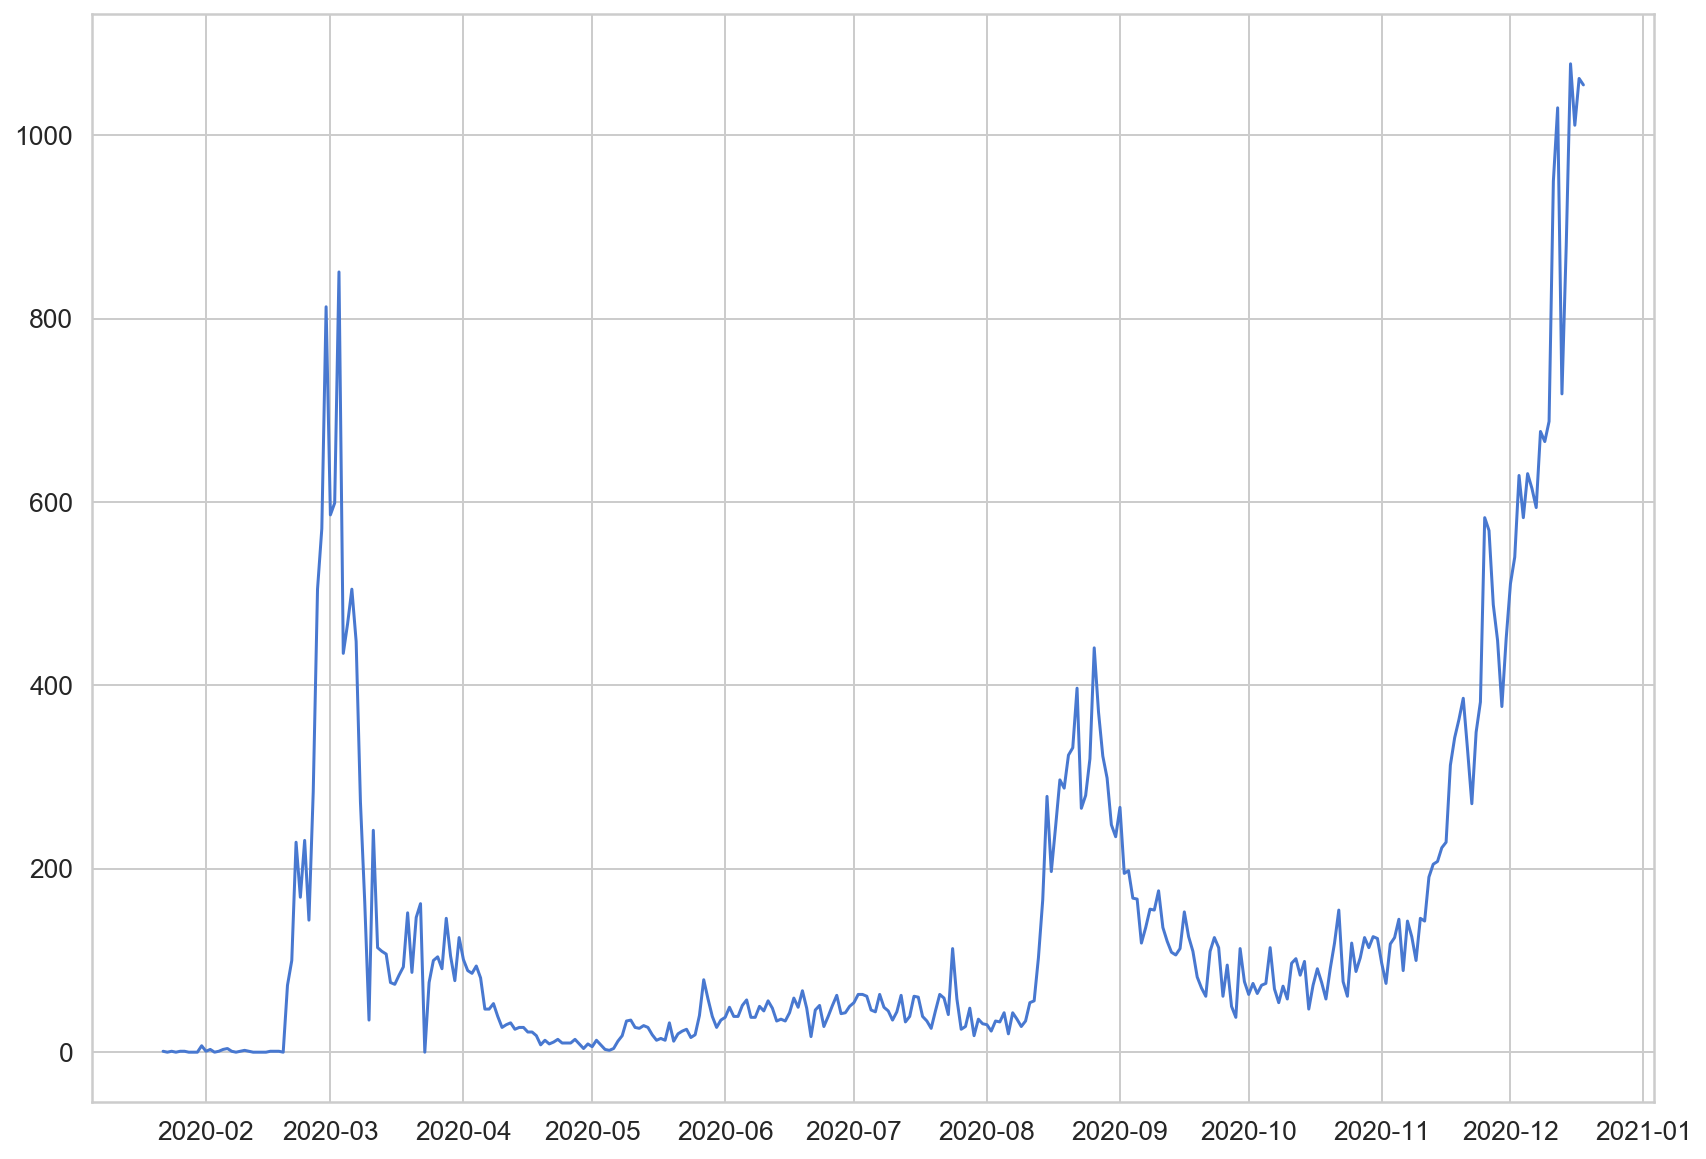

In [34]:
plt.plot(daily_cases.index, daily_cases)

### CNN-LSTM 모델 정의
#### 1D CNN (Conv1D)
- LSTM에 CNN 레이어를 추가하여 예측을 진행
- CNN 모델은 1D, 2D, 3D로 나뉘는데 일반적인 CNN은 보통 이미지 분류에 사용되는 2D를 통칭
- 여기서 D는 차원을 뜻하는 dimensional의 약자로, input 데이터 형태에 따라 1D, 2D, 3D 형태의 CNN 모델이 사용됨
- 1D CNN을 통해 변수간의 지엽적인 특징 추출

In [37]:
"""1D CNN을 정의해서 c에 저장 : 예시"""
c = nn.Conv1d(in_channels = 1, out_channels = 1, kernel_size = 2, stride = 1)
input_ = torch.Tensor([[[1,2,3,4,5]]])
output = c(input_)
output

tensor([[[1.1096, 1.1806, 1.2517, 1.3227]]], grad_fn=<SqueezeBackward1>)

In [42]:
input_.shape

torch.Size([1, 1, 5])

In [40]:
"""Conv1D의 파라미터 확인 (weight와 bias)"""
for param in c.parameters():
    print(param) # kernel size가 2이므로 weight가 2개임

Parameter containing:
tensor([[[-0.3443,  0.4153]]], requires_grad=True)
Parameter containing:
tensor([0.6233], requires_grad=True)


In [58]:
"""weight값 저장"""
w_list = []
for param in c.parameters():
    w_list.append(param)
    
w = w_list[0]
b = w_list[1]

w1 = w[0][0][0]
w2 = w[0][0][1]

print(w1)
print(w2)
print(w3)

tensor(-0.3443, grad_fn=<SelectBackward>)
tensor(0.4153, grad_fn=<SelectBackward>)


NameError: name 'w3' is not defined

### CNN-LSTM 모델 생성
- LSTM 모델과의 가장 큰 차이점은 1D CNN 레이어를 추가한 것

In [68]:
class CNN_LSTM(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CNN_LSTM, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1)
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            num_layers = n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden), #(2, 4, 4)
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden)
        )
    def forward(self, sequences):
        sequences = self.c1(sequences.view(len(sequences), 1, -1))
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len-1, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len-1, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [69]:
"""모델 학습"""
def train_model(model, train_data, train_labels, val_data = None, val_labels=None, num_epochs=100, verbose=10, patience =10):
    loss_fn = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):
        epoch_loss=0
        for idx, seq in enumerate(train_data): # sample별 hidden state reset을 해줘야 한다.
            model.reset_hidden_state()
            
            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss
            
            # update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        train_hist.append(epoch_loss/len(train_data))
        
        if val_data is not None:
            with torch.no_grad():
                val_loss=0
                for val_idx, val_seq in enumerate(val_data):
                    model.reset_hidden_state() # seq별로 hidden state 초기화
                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])
                    
                    val_loss += val_step_loss
                    
                val_hist.append(val_loss / len(val_data))
                
                ## verbose번째 마다 loss 출력
                if t%verbose == 0:
                    print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')
                    
                ## patience번째 마다 early stopping 여부 확인
                if (t%patience==0) & (t!=0):
                    
                    ## 이전 10번째 보다 loss가 커졌다면 early stop
                    if val_hist[t-patience]<val_hist[t]:
                        print('\n Early Stopping')
                        
                        break
        elif t%verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')
            
    return model, train_hist, val_hist
                        

In [70]:
model = CNN_LSTM(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1)

In [71]:
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.16014381702917974 val loss: 0.04056376963853836
Epoch 10 train loss: 0.033719858799622145 val loss: 0.03642548248171806
Epoch 20 train loss: 0.032423808750557316 val loss: 0.038535524159669876
Epoch 30 train loss: 0.032690735086013646 val loss: 0.03749709203839302
Epoch 40 train loss: 0.03238861503479182 val loss: 0.03566946089267731
Epoch 50 train loss: 0.032913597570946335 val loss: 0.03543420881032944
Epoch 60 train loss: 0.03272517489883121 val loss: 0.034666672348976135
Epoch 70 train loss: 0.03219055275029549 val loss: 0.03626551479101181
Epoch 80 train loss: 0.03242937052154992 val loss: 0.034819599241018295
Epoch 90 train loss: 0.032417199841140276 val loss: 0.034828875213861465


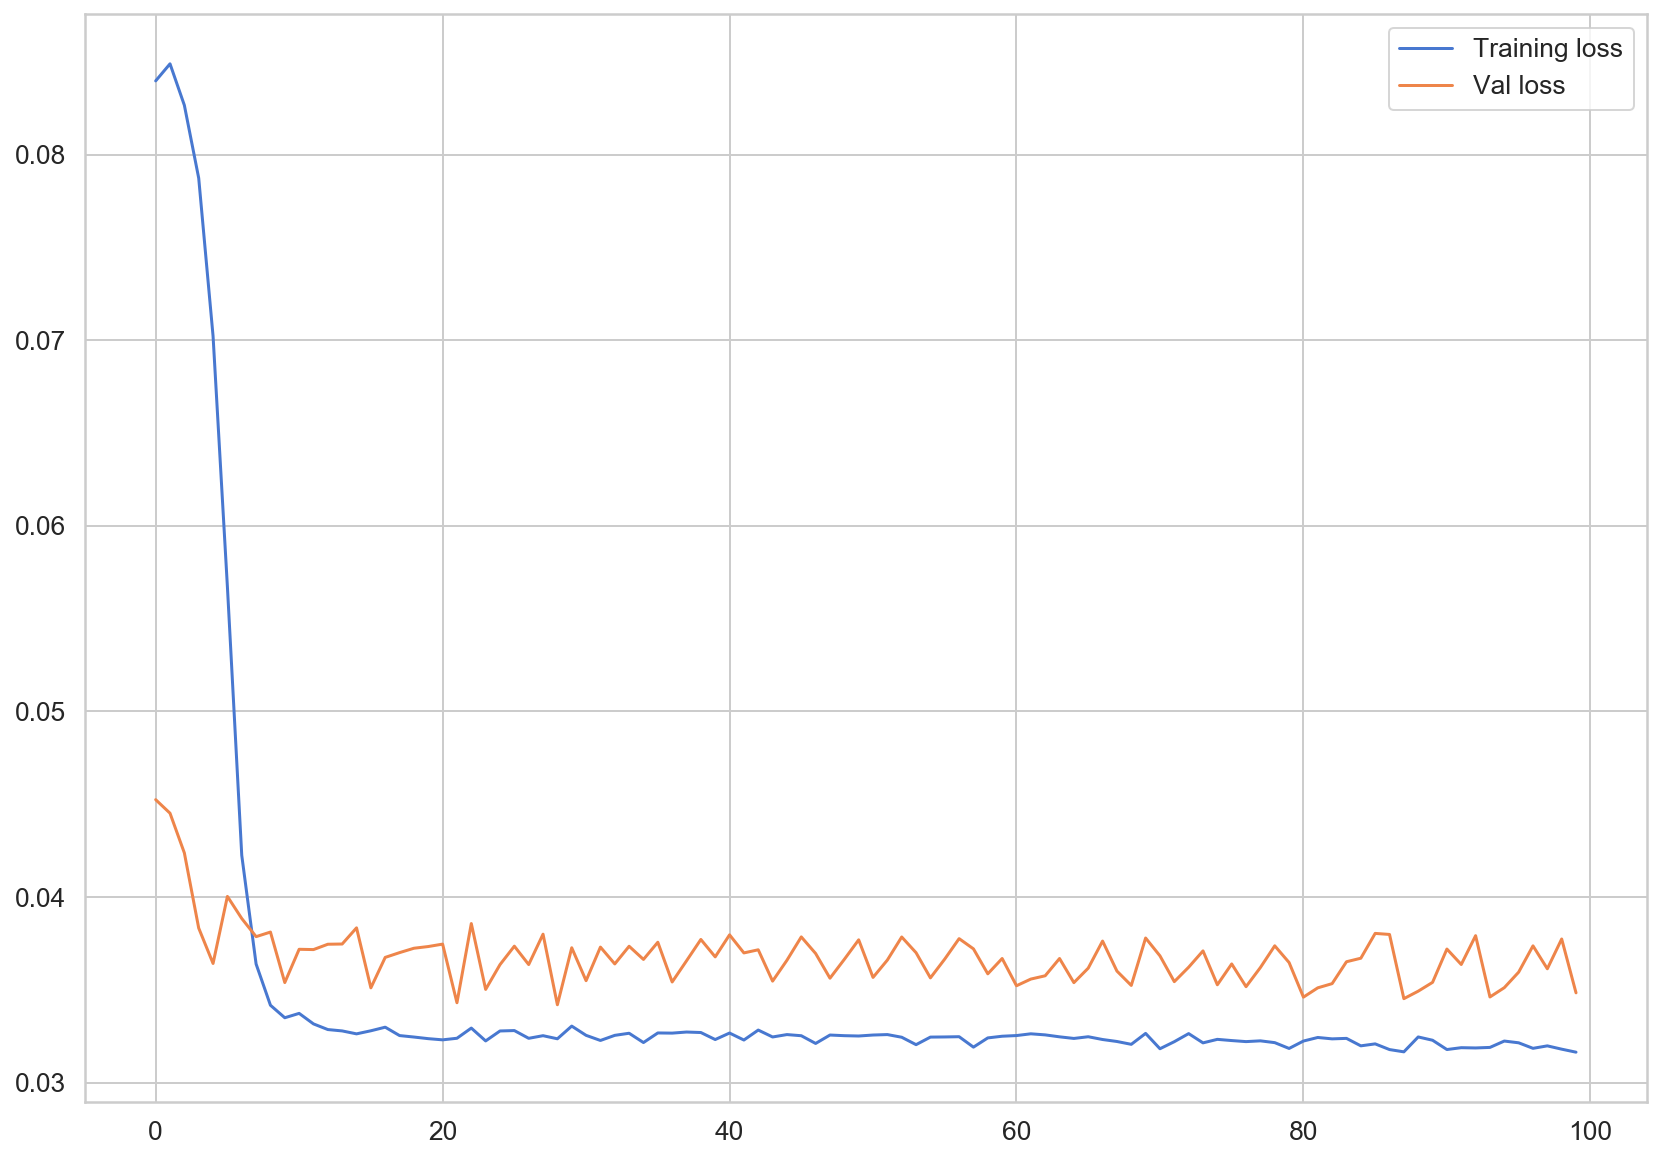

In [59]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

In [85]:
"""예측"""
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        print(y_test_pred)
        print(y_test_pred.shape)
        pred = torch.flatten(y_test_pred).item()
        print(torch.flatten(y_test_pred))
        print()
        preds.append(pred)

tensor([[0.2230]])
torch.Size([1, 1])
tensor([0.2230])

tensor([[0.2319]])
torch.Size([1, 1])
tensor([0.2319])

tensor([[0.3007]])
torch.Size([1, 1])
tensor([0.3007])

tensor([[0.3480]])
torch.Size([1, 1])
tensor([0.3480])

tensor([[0.3718]])
torch.Size([1, 1])
tensor([0.3718])

tensor([[0.3949]])
torch.Size([1, 1])
tensor([0.3949])

tensor([[0.3579]])
torch.Size([1, 1])
tensor([0.3579])

tensor([[0.2954]])
torch.Size([1, 1])
tensor([0.2954])

tensor([[0.3411]])
torch.Size([1, 1])
tensor([0.3411])

tensor([[0.3881]])
torch.Size([1, 1])
tensor([0.3881])

tensor([[0.5354]])
torch.Size([1, 1])
tensor([0.5354])

tensor([[0.5686]])
torch.Size([1, 1])
tensor([0.5686])

tensor([[0.5172]])
torch.Size([1, 1])
tensor([0.5172])

tensor([[0.4725]])
torch.Size([1, 1])
tensor([0.4725])

tensor([[0.4109]])
torch.Size([1, 1])
tensor([0.4109])

tensor([[0.4466]])
torch.Size([1, 1])
tensor([0.4466])

tensor([[0.5054]])
torch.Size([1, 1])
tensor([0.5054])

tensor([[0.5368]])
torch.Size([1, 1])
tensor([0.